In [143]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import sys
sys.path.append("../")

from src.errors import sammon_error

In [75]:
# import numpy as np
# from scipy.spatial.distance import pdist, squareform

# def sammon_error(X, X_low):
#     """
#     Calculate Sammon error (stress) between original data X and low-dimensional data X_low.
    
#     Parameters:
#     - X: Original data (n_samples, n_features)
#     - X_low: Data with selected features or reduced dimensions (n_samples, k_features)
    
#     Returns:
#     - sammon_error: Sammon error (float)
#     """
#     # Compute pairwise distances in the original data
#     D_orig = pdist(X, metric='euclidean')
#     D_orig = squareform(D_orig)  # Convert to a square matrix
    
#     # Compute pairwise distances in the low-dimensional data (selected features)
#     D_low = pdist(X_low, metric='euclidean')
#     D_low = squareform(D_low)
    
#     # Avoid division by zero by replacing zeros with a small number
#     D_orig[D_orig == 0] = np.finfo(float).eps
    
#     # Calculate the Sammon error (Sammon stress)
#     delta = D_orig - D_low
#     sammon_error = np.sum((delta**2) / D_orig)
    
#     # Normalize the error by the sum of original distances
#     sammon_error /= np.sum(D_orig)
    
#     return sammon_error


In [76]:
def ss_sfs(X, max_features=None):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    n_samples, n_features = X_scaled.shape
    selected_features = []
    remaining_features = list(range(n_features))
    best_silhouette = -1
    
    while remaining_features:
        best_feature = None
        best_silhouette_candidate = -1
        
        for feature in remaining_features:
            # Form dataset with currently selected + one candidate feature
            candidate_features = selected_features + [feature]
            X_candidate = X_scaled[:, candidate_features]
            
            # Perform clustering (e.g., KMeans) and calculate silhouette score
            kmeans = KMeans(n_clusters=2, random_state=42)  # You can change n_clusters based on the problem
            labels = kmeans.fit_predict(X_candidate)
            silhouette_avg = silhouette_score(X_candidate, labels)
            
            if silhouette_avg > best_silhouette_candidate:
                best_silhouette_candidate = silhouette_avg
                best_feature = feature
        
        if best_silhouette_candidate > best_silhouette:
            best_silhouette = best_silhouette_candidate
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break  # Stop if silhouette score does not improve
        
        # Stop if max_features is reached
        if max_features and len(selected_features) >= max_features:
            break
    
    return selected_features

In [163]:
def sammon_sfs(X, max_features):

    n_samples, n_features = X.shape
    selected_features = []
    remaining_features = list(range(n_features))
    best_sammon_error = np.inf  # Start with a high Sammon error
    
    while remaining_features:
        best_feature = None
        best_sammon_candidate = np.inf
        
        for feature in remaining_features:
            # Form dataset with currently selected + one candidate feature
            candidate_features = selected_features + [feature]
            X_candidate = X[:, candidate_features]
            
            # print(candidate_features)
            
            # Calculate Sammon error
            bool_mask = np.zeros(X.shape[1], dtype=bool)  # Initialize a mask of all False
            bool_mask[candidate_features] = True  # Set True for selected indices
            error = sammon_error(X, bool_mask)
            
            if error < best_sammon_candidate:
                best_sammon_candidate = error
                best_feature = feature
        
        if best_sammon_candidate < best_sammon_error:
            best_sammon_error = best_sammon_candidate
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break  # Stop if Sammon error does not improve
        
        # Stop if max_features is reached
        if len(selected_features) >= max_features:
            break
    
    return selected_features

In [164]:
data = pd.read_csv("../data/data_class.csv", sep=',')
data.head()

,repository,LCOM5,WMC,CBO,NOI,RFC,CLOC,DIT,NOA,NOC,...,LOC,LLOC,NM,NLM,NOS,TLOC,TLLOC,TNM,TNLM,TNOS
0,freqtrade_freqtrade,2.634006,12.495677,0.239193,0.060519,4.144092,22.224784,0.259366,0.259366,0.167147,...,89.314121,70.216138,4.469741,4.083573,29.268012,90.043228,70.688761,4.510086,4.100865,29.582133
1,oobabooga_text-generation-webui,3.683333,11.916667,0.233333,0.116667,4.666667,4.250000,0.166667,0.166667,0.150000,...,59.383333,45.016667,5.416667,4.550000,32.733333,59.383333,45.016667,5.466667,4.550000,32.733333
2,matplotlib_matplotlib,3.996614,13.980813,0.680587,0.638826,6.335214,40.407449,0.542889,0.572235,0.345372,...,104.386005,83.202032,14.445824,5.696388,35.501129,106.364560,84.685102,14.651242,5.808126,36.108352
3,OpenBB-finance_OpenBBTerminal,5.988593,27.733840,0.064639,0.186312,7.612167,34.817490,0.011407,0.011407,0.011407,...,269.106464,236.585551,7.623574,7.425856,66.969582,269.114068,236.577947,7.661597,7.425856,66.969582
4,huggingface_diffusers,3.369406,16.808788,0.240033,0.391375,5.538649,31.545972,0.039056,0.039056,0.031733,...,152.087876,117.532140,5.262002,5.147274,51.539463,152.091945,117.534581,5.455655,5.157038,51.571196


In [165]:
def get_X(path):
    data = pd.read_csv(path, sep=',')
    X = data.drop(columns=["repository"], inplace=False)
    X = X.to_numpy()
    return data, X

In [166]:
data_class, X_class = get_X("../data/data_class.csv")
data_method, X_method = get_X("../data/data_method.csv")

data_class.shape, data_method.shape

((128, 22), (106, 22))

In [167]:
def run_sammon_sfs(X, data, max_features):
    selected_features = sammon_sfs(X, max_features=max_features)
    selected_data = data.drop(columns=["repository"]).iloc[:, selected_features]
    # print("Selected features:", selected_data.columns)

    bool_mask = np.zeros(X.shape[1], dtype=bool)  # Initialize a mask of all False
    bool_mask[selected_features] = True  # Set True for selected indices
    error = sammon_error(X, bool_mask)
    # print(selected_features)
    # print("Sammon error:", error)
    return error, [data.drop(columns=['repository']).columns[feature] for feature in selected_features]

In [168]:
def test_sammon_sfs(X, data, max_features):
    error, selected_features = run_sammon_sfs(X, data, max_features)
    
    print("Selected features:", selected_features)
    # print(selected_features)
    print("Sammon error:", error)

In [169]:
test_sammon_sfs(X_class, data_class, max_features=X_class.shape[1])

Selected features: ['LOC', 'TLOC', 'LLOC', 'TLLOC', 'TNOS', 'CLOC', 'NOS', 'WMC', 'TNM', 'NM', 'RFC', 'TNLM', 'NLM', 'LCOM5', 'CBO', 'NOA', 'NOD', 'DIT', 'NOI', 'NOC', 'NOP']
Sammon error: 1.99403504986271e-20


In [170]:
test_sammon_sfs(X_method, data_method, max_features=X_method.shape[1])

Selected features: ['HEFF', 'MI', 'HVOL', 'TLOC', 'LOC', 'TLLOC', 'HCPL', 'CLOC', 'LLOC', 'DLOC', 'TCLOC', 'TNOS', 'HTRP', 'NOS', 'HPL', 'NUMPAR', 'HPV', 'McCC', 'NOI', 'HDIF', 'HNDB']
Sammon error: 1.3786943288452742e-20


In [171]:
def run_sammon_sfs_for_iters(X, data, N):
    errors = [1]
    num_ftrs = [0]
    selected_features = [[]]
    for n in range(1, N):
        error, selected_data = run_sammon_sfs(X, data, n)
        errors.append(float(error))
        num_ftrs.append(n)
        selected_features.append(selected_data)
        
    return errors, num_ftrs, selected_features

In [172]:
errors, num_ftrs, selected_features = run_sammon_sfs_for_iters(X_class, data_class, data_class.shape[1])
num_ftrs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [173]:
selected_features

[[],
 ['LOC'],
 ['LOC', 'TLOC'],
 ['LOC', 'TLOC', 'LLOC'],
 ['LOC', 'TLOC', 'LLOC', 'TLLOC'],
 ['LOC', 'TLOC', 'LLOC', 'TLLOC', 'TNOS'],
 ['LOC', 'TLOC', 'LLOC', 'TLLOC', 'TNOS', 'CLOC'],
 ['LOC', 'TLOC', 'LLOC', 'TLLOC', 'TNOS', 'CLOC', 'NOS'],
 ['LOC', 'TLOC', 'LLOC', 'TLLOC', 'TNOS', 'CLOC', 'NOS', 'WMC'],
 ['LOC', 'TLOC', 'LLOC', 'TLLOC', 'TNOS', 'CLOC', 'NOS', 'WMC', 'TNM'],
 ['LOC', 'TLOC', 'LLOC', 'TLLOC', 'TNOS', 'CLOC', 'NOS', 'WMC', 'TNM', 'NM'],
 ['LOC',
  'TLOC',
  'LLOC',
  'TLLOC',
  'TNOS',
  'CLOC',
  'NOS',
  'WMC',
  'TNM',
  'NM',
  'RFC'],
 ['LOC',
  'TLOC',
  'LLOC',
  'TLLOC',
  'TNOS',
  'CLOC',
  'NOS',
  'WMC',
  'TNM',
  'NM',
  'RFC',
  'TNLM'],
 ['LOC',
  'TLOC',
  'LLOC',
  'TLLOC',
  'TNOS',
  'CLOC',
  'NOS',
  'WMC',
  'TNM',
  'NM',
  'RFC',
  'TNLM',
  'NLM'],
 ['LOC',
  'TLOC',
  'LLOC',
  'TLLOC',
  'TNOS',
  'CLOC',
  'NOS',
  'WMC',
  'TNM',
  'NM',
  'RFC',
  'TNLM',
  'NLM',
  'LCOM5'],
 ['LOC',
  'TLOC',
  'LLOC',
  'TLLOC',
  'TNOS',
  'CLOC',


In [174]:
df_sfs_class = pd.DataFrame({
    "number_of_features": num_ftrs,
    "error": errors,
})
df_sfs_class

,number_of_features,error
0,0,1.000000e+00
1,1,2.571245e-01
2,2,9.754496e-02
3,3,4.319395e-02
4,4,1.850169e-02
5,5,7.790031e-03
6,6,3.192803e-03
7,7,6.633146e-04
8,8,2.659712e-04
9,9,9.463050e-05


In [175]:
df_sfs_class.to_csv("../data/results/SFS_class.csv", index=False)

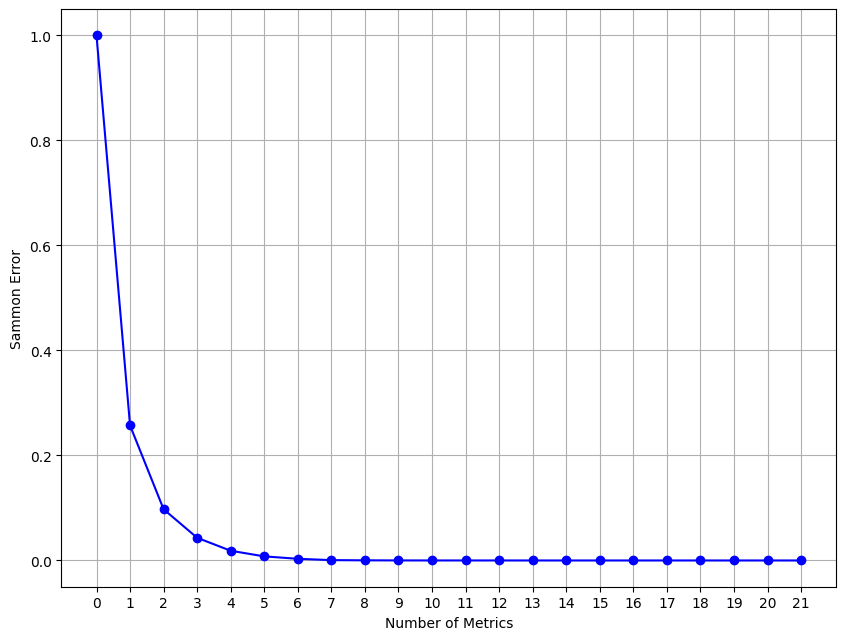

In [176]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Metrics')
plt.ylabel('Sammon Error')
# plt.title('Sammon Error vs Number of Features')
plt.xticks(num_ftrs)  # Ensure x-axis ticks are integers from all_num_ftrs
plt.grid(True)
plt.show()

In [177]:
selected_features_ = [""]
selected_features_.extend(selected_features[-1])
selected_features_

['',
 'LOC',
 'TLOC',
 'LLOC',
 'TLLOC',
 'TNOS',
 'CLOC',
 'NOS',
 'WMC',
 'TNM',
 'NM',
 'RFC',
 'TNLM',
 'NLM',
 'LCOM5',
 'CBO',
 'NOA',
 'NOD',
 'DIT',
 'NOI',
 'NOC',
 'NOP']

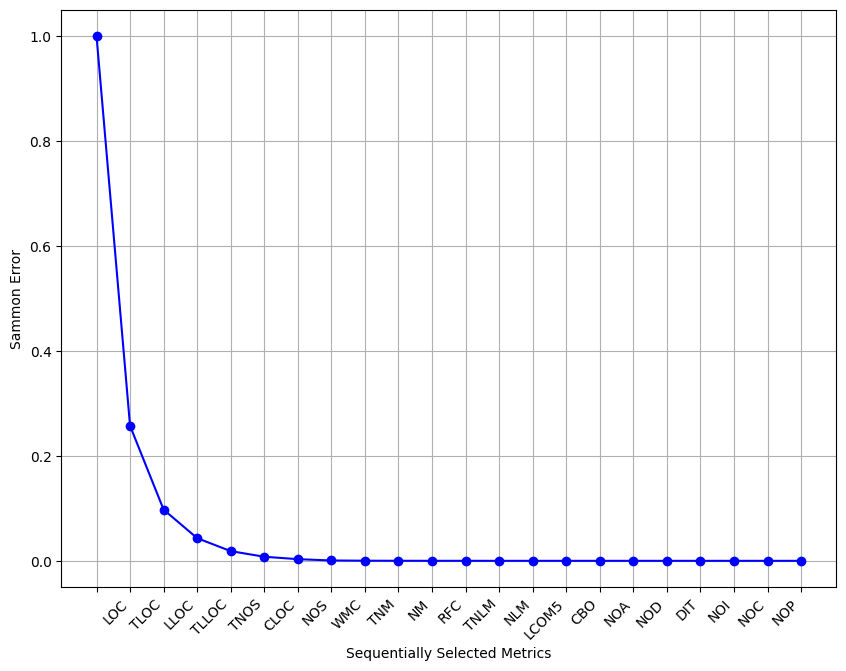

In [178]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Sequentially Selected Metrics')
plt.ylabel('Sammon Error')
# plt.title('Sammon Error vs Number of Features')
plt.xticks(num_ftrs, selected_features_, rotation=45, ha='right')  # Map indices to feature names
plt.grid(True)
plt.show()

In [179]:
errors, num_ftrs, selected_features = run_sammon_sfs_for_iters(X_method, data_method, data_method.shape[1])
num_ftrs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [180]:
df_sfs_method = pd.DataFrame({
    "number_of_features": num_ftrs,
    "error": errors,
})
df_sfs_method

,number_of_features,error
0,0,1.000000e+00
1,1,1.181389e-02
2,2,3.328872e-03
3,3,1.959680e-03
4,4,1.035626e-03
5,5,5.286543e-04
6,6,3.401806e-04
7,7,2.406671e-04
8,8,1.527718e-04
9,9,8.257897e-05


In [181]:
df_sfs_method.to_csv("../data/results/SFS_method.csv", index=False)

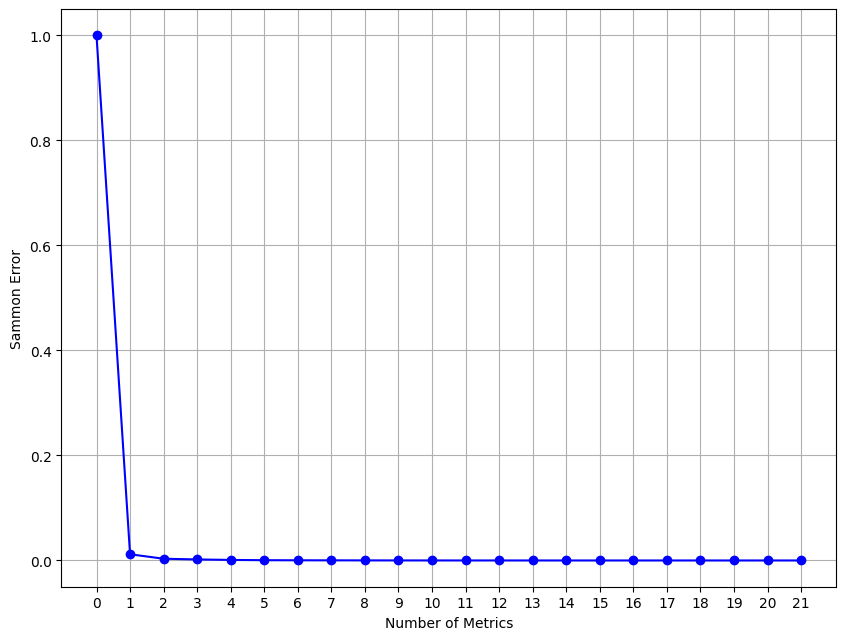

In [182]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Metrics')
plt.ylabel('Sammon Error')
# plt.title('Sammon Error vs Number of Features')
plt.xticks(num_ftrs)  # Ensure x-axis ticks are integers from all_num_ftrs
plt.grid(True)
plt.show()

In [183]:
selected_features_ = [""]
selected_features_.extend(selected_features[-1])

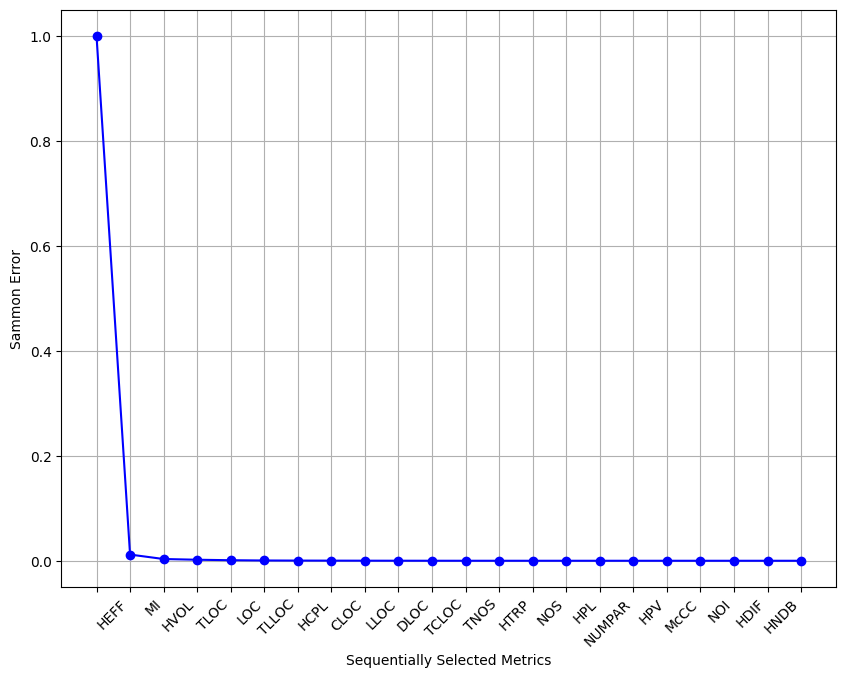

In [184]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Sequentially Selected Metrics')
plt.ylabel('Sammon Error')
# plt.title('Sammon Error vs Number of Features')
plt.xticks(num_ftrs, selected_features_, rotation=45, ha='right')  # Map indices to feature names
plt.grid(True)
plt.show()


In [185]:
errors

[1,
 0.011813886698870594,
 0.0033288724293837465,
 0.0019596797875874477,
 0.0010356259630160299,
 0.0005286542611848264,
 0.0003401806494834744,
 0.00024066709112713168,
 0.00015277183301155552,
 8.25789734389321e-05,
 3.565675313291061e-05,
 1.5385372147926834e-05,
 9.699272098436916e-06,
 5.086110113982163e-06,
 2.48347945077117e-06,
 8.384727565202722e-07,
 2.825122662799603e-07,
 7.214705722190872e-08,
 3.008120346638116e-10,
 9.435473991276468e-11,
 4.170330986079913e-18,
 1.3786943288452742e-20]

---

In [100]:
errors, selected_features = run_sammon_sfs(X_class, data_class, max_features=X_class.shape[1])

In [101]:
errors, selected_features

(np.float64(1.9940350498644993e-20),
 ['LOC',
  'TLOC',
  'LLOC',
  'TLLOC',
  'TNOS',
  'CLOC',
  'NOS',
  'WMC',
  'TNM',
  'NM',
  'RFC',
  'TNLM',
  'NLM',
  'LCOM5',
  'CBO',
  'NOA',
  'NOD',
  'DIT',
  'NOI',
  'NOC',
  'NOP'])